# R-Bloggers Beta Prior , Binomial Sampling to Posterior Probability Example

This is a notebooked version of a great example I found on plotting a posterior probability from a simple beta prior and binomial sampled likelihood function.

Link is here: [R-Bloggers Example](https://www.r-bloggers.com/the-beta-prior-likelihood-and-posterior/)


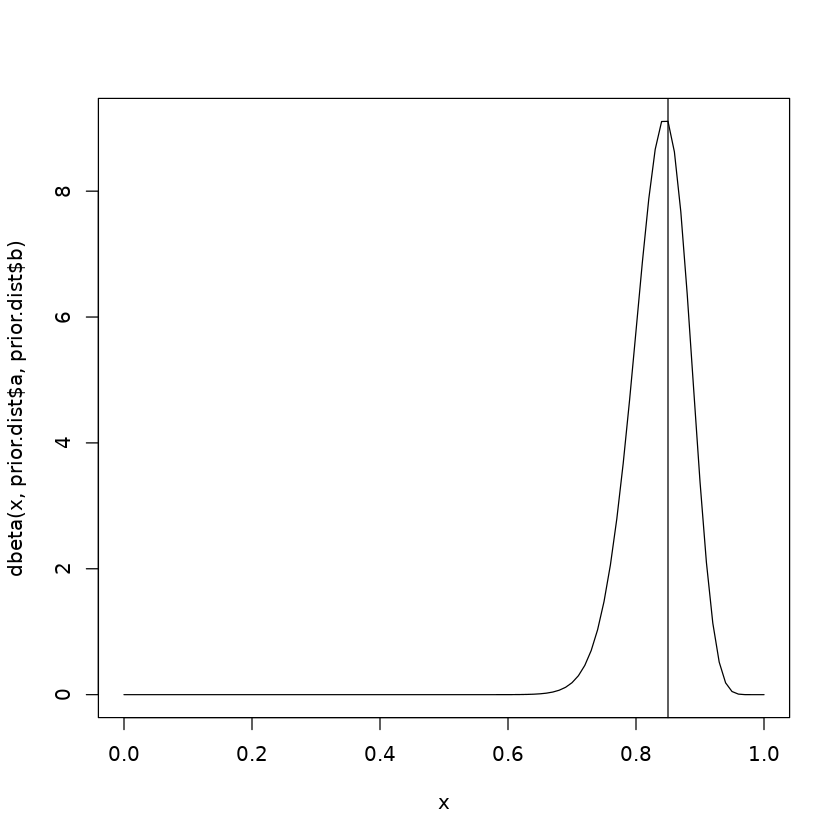

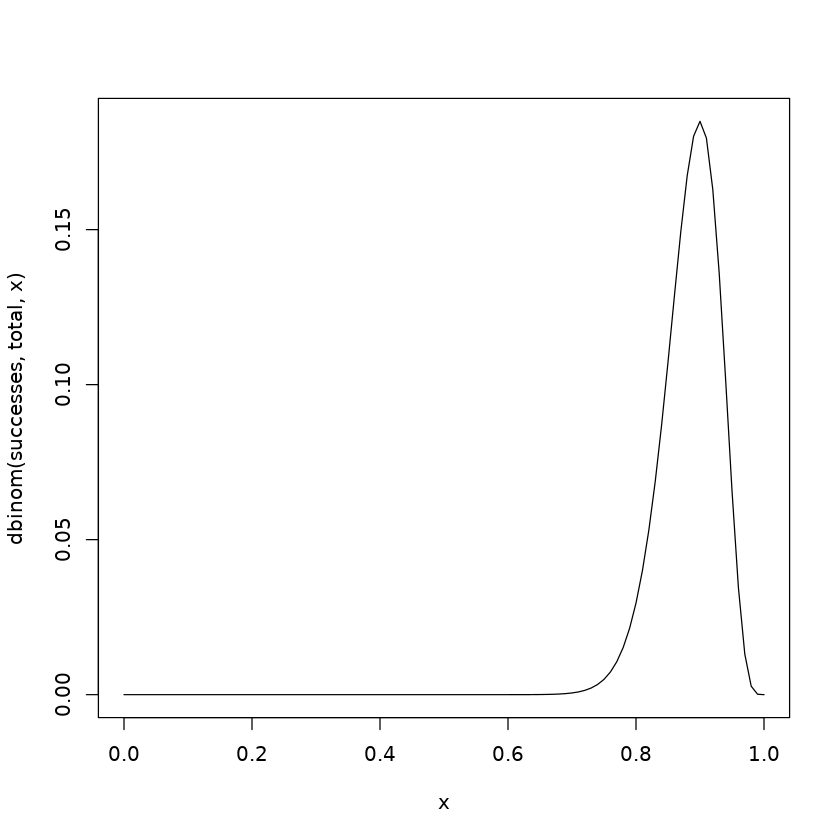

In [1]:
library(LearnBayes)
Q = data.frame(
    quantile=c(
        median=0.5,
        maximum=0.99999,
        minimum=0.00001),
    prior=c(
        median=0.85,
        maximum=0.95,
        minimum=0.60)
)
 
optimalBeta = function(Q) {
    q1q = Q$quantile[1]
    q1p = Q$prior[1]
    q2q = Q$quantile[2]
    q2p = Q$prior[2]
    q3q = Q$quantile[3]
    q3p = Q$prior[3]

    # find the beta prior using quantile1 and quantile2
    q.med = list(p=q1q, x=q1p)
    q.max = list(p=q2q, x=q2p)
    q.min = list(p=q3q, x=q3p)

    # prior parameters using median and max, and median and min
    prior.A = beta.select(q.med,q.max)
    prior.B = beta.select(q.med,q.min)

    prior.Aa = prior.A[1]
    prior.Ab = prior.A[2]

    prior.Ba = prior.B[1]
    prior.Bb = prior.B[2]

    ## find the best possible beta prior
    ## Set a start and stop point range to find the best parameters
    if (prior.Aa < prior.Ba) {
        start.a = prior.Aa
        stop.a = prior.Ba
    } else {
        start.a = prior.Ba
        stop.a = prior.Aa
    }

    if (prior.Ab < prior.Bb) {
        start.b = prior.Ab
        stop.b = prior.Bb
    } else {
        start.b = prior.Bb
        stop.b = prior.Ab
    }
    seq.a = seq(from=start.a, to=stop.a, length.out=1000)
    seq.b = seq(from=start.b, to=stop.b, length.out=1000)

    seq.grid = expand.grid(seq.a, seq.b)

    prior.C.q1 = qbeta(q1q, seq.grid[,1], seq.grid[,2])
    prior.C.q2 = qbeta(q2q, seq.grid[,1], seq.grid[,2])
    prior.C.q3 = qbeta(q3q, seq.grid[,1], seq.grid[,2])

    ## Different distance measurements, manhattan, euclidean, or otherwise.
    ## It would be interesting to run a simulation to measure a variety of distance measurements.
    ##prior.C.delta = abs(prior.C.q1 - q1p) + abs(prior.C.q2 - q2p) + abs(prior.C.q3 - q3p)
    prior.C.delta = sqrt( (prior.C.q1 - q1p)^2 + (prior.C.q2 - q2p)^2 + (prior.C.q3 - q3p)^2 )

    optimize.seq = cbind(seq.grid, prior.C.q1, prior.C.q2, prior.C.q3, prior.C.delta)

    ## Minimize the delta, if the min-delta is not unique then choose the first occurence
    best.a = optimize.seq[,1][ optimize.seq[,6] == min(optimize.seq[,6])][1]
    best.b = optimize.seq[,2][ optimize.seq[,6] == min(optimize.seq[,6])][1]

    return(list(a=best.a,b=best.b))
}
 
prior.dist = optimalBeta(Q)
 
##########################################################
## Take a look at only the prior
##########################################################
curve(dbeta(x,prior.dist$a,prior.dist$b)) # plot the prior
abline(v=Q$prior[1])
 
##########################################################
## Take a look at only the likelihood with given successes
##########################################################
calcLikelihood = function(successes, total){
    curve(dbinom(successes,total,x)) # plot the likelihood
}

calcLikelihood(45, 50) ## e.g. 45/50 sucesses
## calculate some properties of the Beta distribution
calcBetaMode = function(aa, bb) {
    beta.mode = (aa - 1)/(aa + bb - 2)
    return(beta.mode)
}
calcBetaMean = function(aa, bb) {
    beta.mean = (aa)/(aa + bb)
    return(beta.mean)
}
calcBetaVar = function(aa, bb) {
    beta.var = (aa * bb)/(((aa + bb)^2) * (aa + bb + 1))
    return(beta.var)
}
calcBetaMedian = function(aa, bb) {
    beta.med = (aa-1/3)/(aa+bb-2/3)
    return(beta.med)
}
calcBetaSkew = function(aa, bb) {
    beta.skew = ( 2*(bb-aa)*sqrt(aa+bb+1) ) /( (aa+bb+2)/sqrt(aa+bb) )
    return(beta.skew)
}
 


[1] "Mode: prior= 0.121212121212121 ; Likelihood= 0.5 ; Posterior= 0.349397590361446"
[1] "Mean: prior= 0.142857142857143 ; Likelihood= 0.5 ; Posterior= 0.352941176470588"
[1] "~Approx Median (for a and b > 1): prior= 0.135922330097087 ; Likelihood= 0.5 , for Posterior= 0.351778656126482"
[1] "Var: prior= 0.00340136054421769 ; Likelihood= 0.00471698113207547 ; Posterior= 0.00265550816769936"
[1] "Skewness: prior= 47.9682144575645 ; Likelihood= 0 ; Posterior= 49.1370908041358"


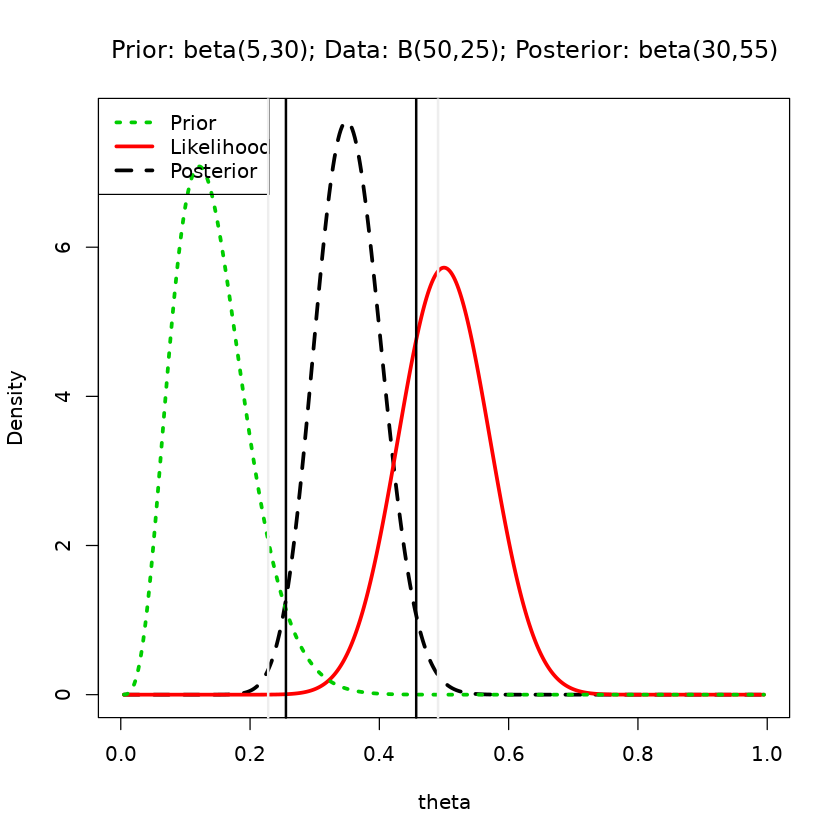

In [3]:

##########################################################
## Take a look at the prior, likelihood, and posterior
##########################################################

priorToPosterior = function(successes, total, a, b) {
    
    ## Note the rule of succession
    likelihood.a = successes + 1
    likelihood.b = total - successes + 1

    ## Create posterior
    posterior.a = a + successes;
    posterior.b = b + total - successes
    theta = seq(0.005, 0.995, length = 500)

    ## Calc density
    prior = dbeta(theta, a, b)
    likelihood = dbeta(theta, likelihood.a, likelihood.b)
    posterior = dbeta(theta, posterior.a, posterior.b)

    ## Plot prior, likelihood, and posterior

    ## Can be used to scale down the graph if desired.
    ## However, the density is different for each prior, likelihood, posterior
    m.orig = apply( cbind(prior, likelihood, posterior), 2, max)
    m = max(c(prior, likelihood, posterior))

    plot(theta, posterior, type = "l", ylab = "Density", lty = 2, lwd = 3,
    main = paste("Prior: beta(", round(a,2), ",", round(b,2), "); Data: B(", total, ",", successes, "); ",
    "Posterior: beta(", round(posterior.a,2), ",", round(posterior.b,2), ")", sep=""), ylim = c(0, m), col = 1)
    lines(theta, likelihood, lty = 1, lwd = 3, col = 2)
    lines(theta, prior, lty = 3, lwd = 3, col = 3)
    legend("topleft",y=m, c("Prior", "Likelihood", "Posterior"), lty = c(3, 1, 2),
    lwd = c(3, 3, 3), col = c(3, 2, 1))

    prior.mode = calcBetaMode(a, b)
    likelihood.mode = calcBetaMode(likelihood.a, likelihood.b)
    posterior.mode = calcBetaMode(posterior.a, posterior.b)
    prior.mean = calcBetaMean(a, b)
    likelihood.mean = calcBetaMean(likelihood.a, likelihood.b)
    posterior.mean = calcBetaMean(posterior.a, posterior.b)
    prior.med = calcBetaMedian(a, b)
    likelihood.med = calcBetaMedian(likelihood.a, likelihood.b)
    posterior.med = calcBetaMedian(posterior.a, posterior.b)
    prior.var = calcBetaVar(a, b)
    likelihood.var = calcBetaVar(likelihood.a, likelihood.b)
    posterior.var = calcBetaVar(posterior.a, posterior.b)
    prior.skew = calcBetaSkew(a, b)
    likelihood.skew = calcBetaSkew(likelihood.a, likelihood.b)
    posterior.skew = calcBetaSkew(posterior.a, posterior.b)

    print(paste("Mode: prior=",prior.mode,"; Likelihood=",likelihood.mode,"; Posterior=",posterior.mode))
    print(paste("Mean: prior=",prior.mean,"; Likelihood=",likelihood.mean,"; Posterior=",posterior.mean))
    print(paste("~Approx Median (for a and b > 1): prior=",prior.med,"; Likelihood=",likelihood.med,", for Posterior=",posterior.med))
    print(paste("Var: prior=",prior.var,"; Likelihood=", likelihood.var,"; Posterior=",posterior.var))
    print(paste("Skewness: prior=",prior.skew,"; Likelihood=",likelihood.skew,"; Posterior=",posterior.skew))
    return(list(a=posterior.a,b=posterior.b))
}
 
#posterior.out = priorToPosterior(25,50, prior.dist$a, prior.dist$b) # 25/50 is current data
posterior.out = priorToPosterior(25,50, 5, 30) # 25/50 is current data
beta.sim = rbeta(1000000,posterior.out$a, posterior.out$b)
abline(v=quantile(beta.sim, prob=c(.05/2, 1-.05/2)), col='#000000', lwd=2)
abline(v=quantile(beta.sim, prob=c(.01/2, 1-.01/2)), col='#EEEEEE', lwd=2)